In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))

suppressMessages(library(openair))
suppressMessages(library(BBmisc))
suppressMessages(library(caret))

In [2]:
suppressMessages(library(doMC))
registerDoMC(cores=as.integer(detectCores()*0.75))

In [3]:
suppressMessages(library(repr))
options(repr.plot.width=20,
        repr.plot.height=20,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [4]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

## Load Data

In [5]:
load("data/data_AQ.rda")
load("data/meteorology.rda")

aq <- data_AQ %>%
        filter(site == "es0118a") %>%
        timeAverage(avg.time = "day", type="variable")
aq$date <- as_date(aq$date)

mto <- data_Mto[data_Mto$site == "es0118a", ]

df <- merge(aq, mto,
              by = "date", all.x=T) %>%
        drop_na() %>%
        select(-date_end, -process, -summary, -validity, -site)

rm(data_AQ)
rm(data_Mto)

In [6]:
main <- function(pll, df) {
    
    
    df <- df %>%
            filter(variable == pll)
    
    
    
    train <- which(df$date < ymd("2020-01-01"))
    test <- which(df$date > ymd("2020-01-01"))
    
    data.df <- df %>%
                select(-date, -variable) %>%
                normalize(method = "range", 
                          range = c(0, 1), margin = 1)
    
    # Set up the resampling, here repeated CV
    tr <- trainControl(method = "repeatedcv",
                       number = 10, repeats = 5)
    
    model <- train(value ~., data=data.df, subset=train,
                   na.action=na.omit,
                   method="knn", 
                   trControl = tr,
                   tuneGrid=data.frame(k=10),
                   allowParallel = TRUE)
    
    data.frame(variable = rep(pll, nrow(df[,])),
               time = df[, "date"],
               pred = predict(model, newdata=data.df[, ]),
               obs = data.df[,]$value
              )    
}

In [7]:
model.df <-do.call(rbind, 
                   lapply(levels(as.factor(df$variable)), 
                          main, df))

In [8]:
head(model.df)

,variable,time,pred,obs
,<chr>,<date>,<dbl>,<dbl>
1,no,2013-01-01,0.2244750,0.1164829
2,no,2013-01-02,0.2685885,0.3625925
3,no,2013-01-03,0.2431584,0.2733041
4,no,2013-01-05,0.4512550,0.6349902
5,no,2013-01-06,0.4448093,0.4011180
6,no,2013-01-07,0.3314877,0.1371808


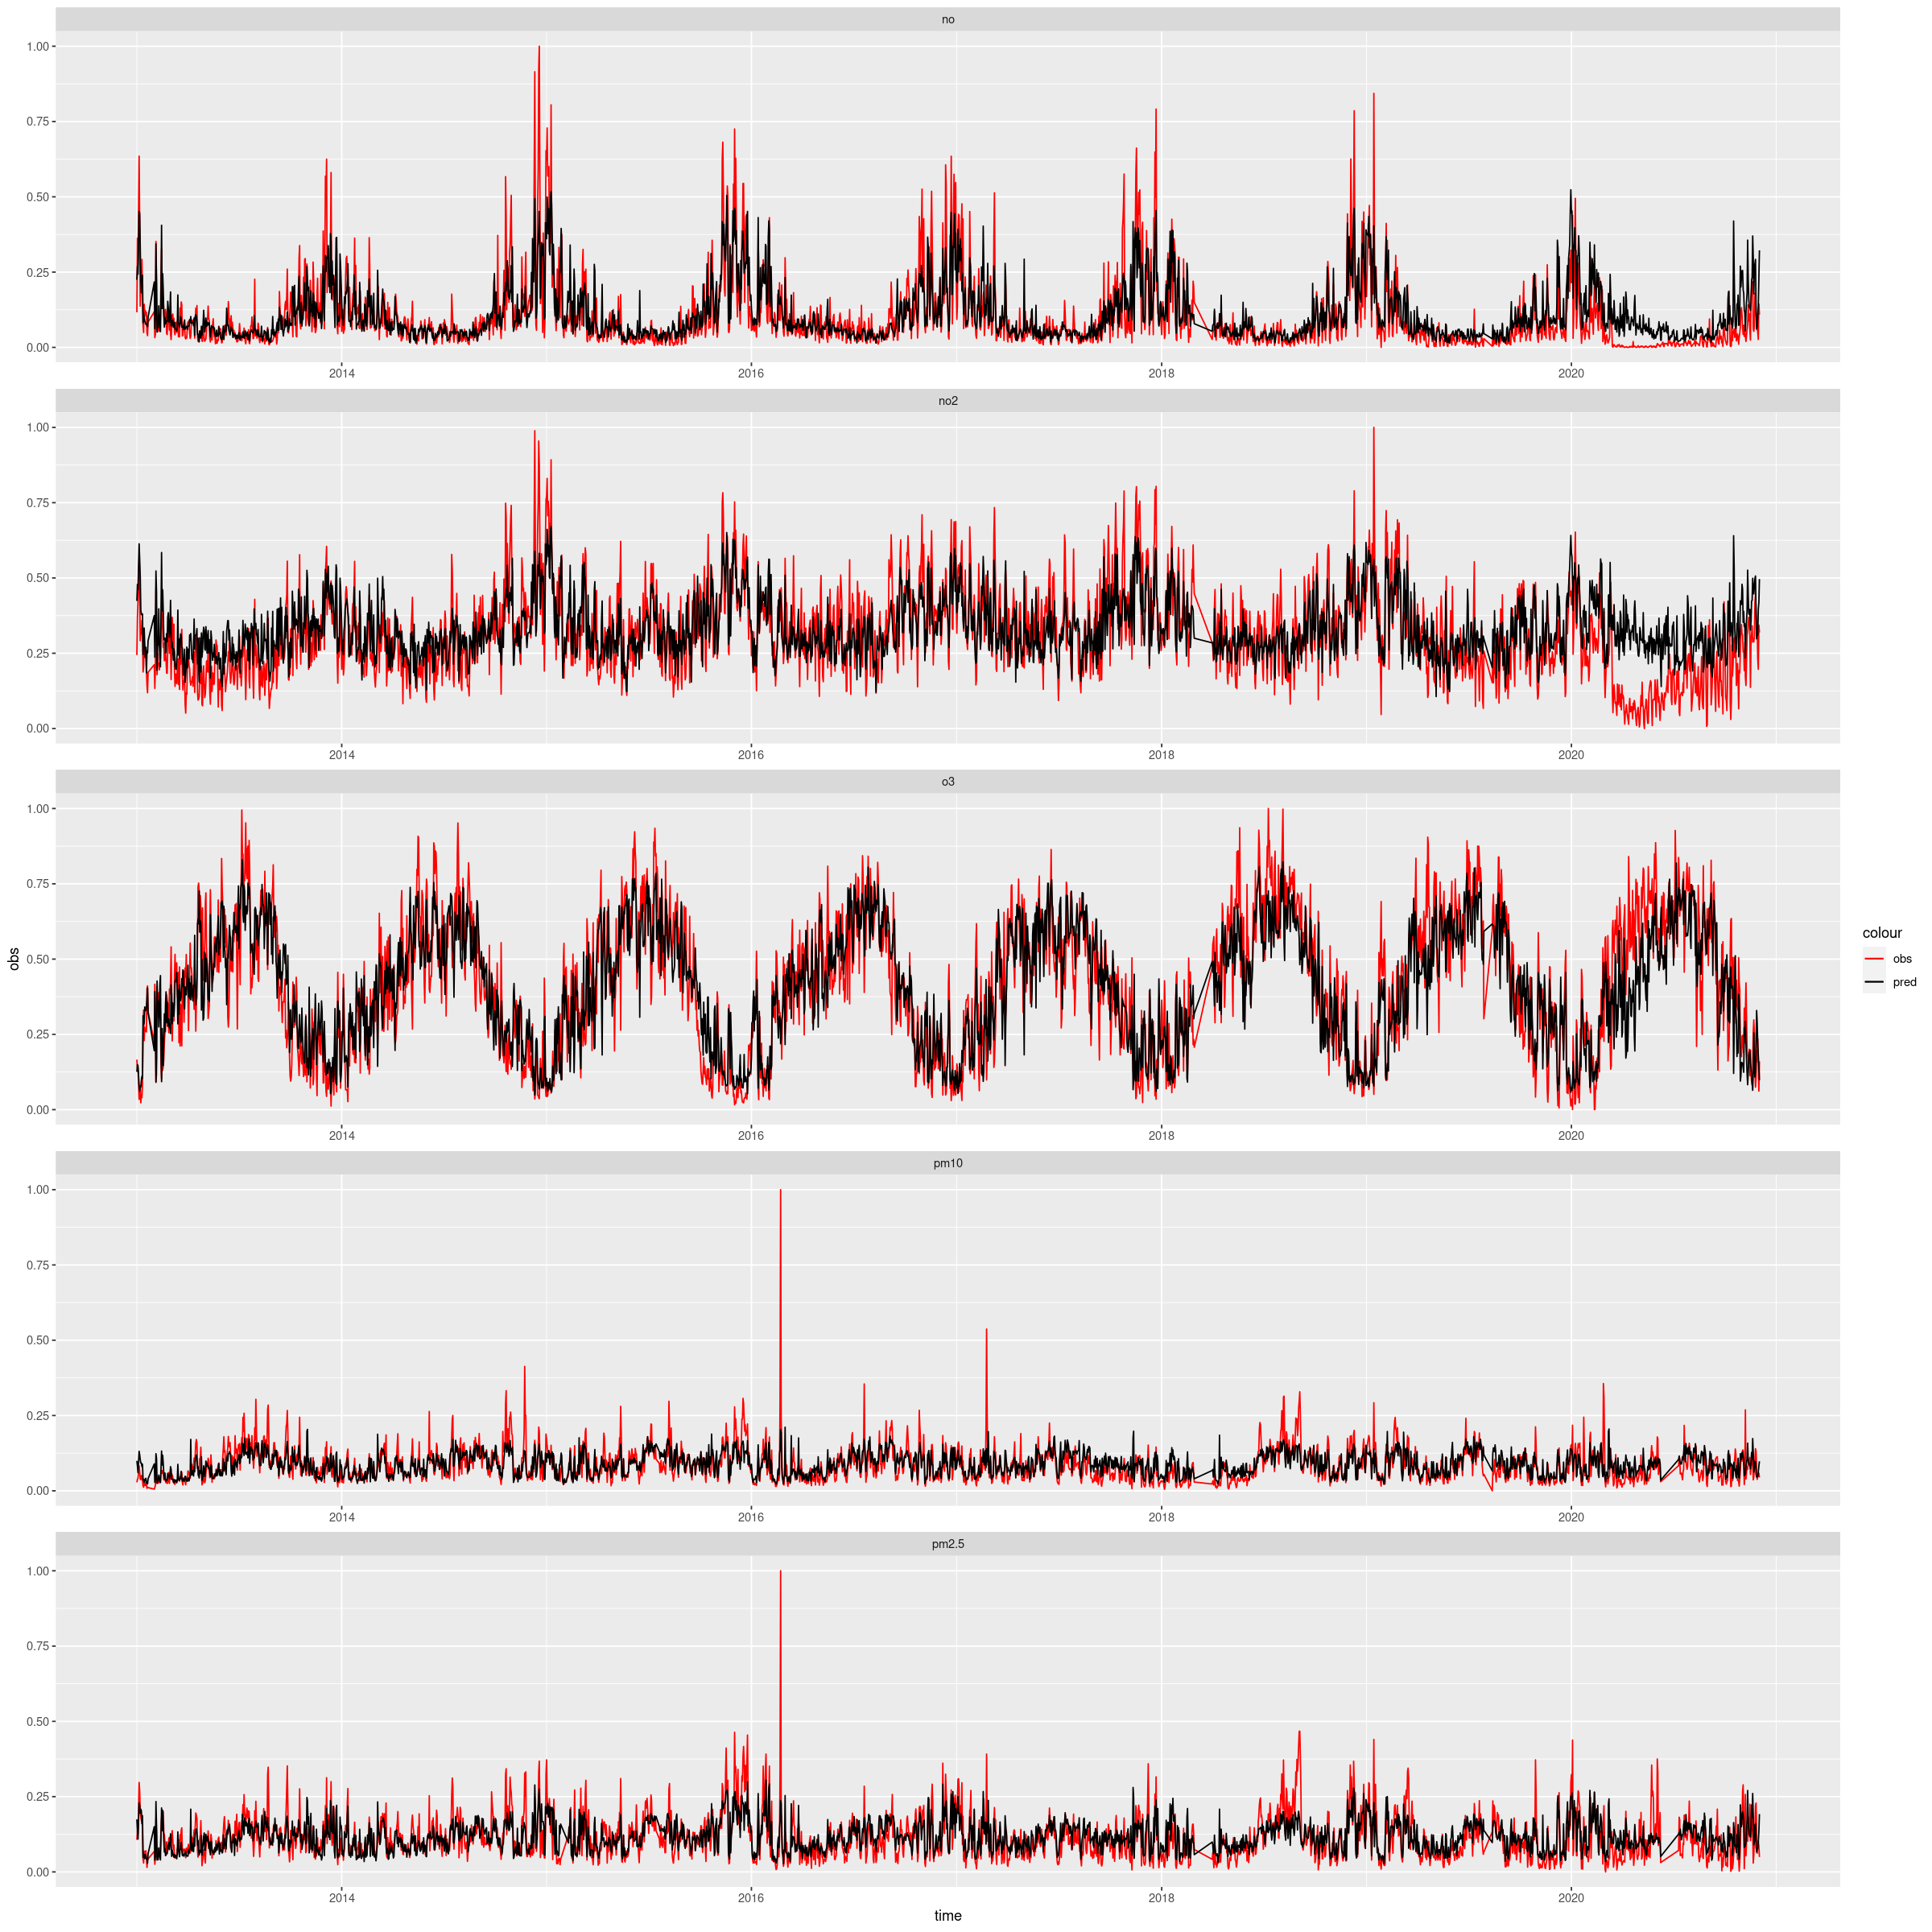

In [9]:
ggplot(data=model.df) +
    scale_color_manual(values=c("obs" = "red",
                         "pred" = "black")) +
    geom_line(aes(x=time, y=obs, color = "obs")) +
    geom_line(aes(x=time, y=pred, color = "pred")) +
    facet_wrap(~variable, scale="free", ncol=1)

In [10]:
model.df$diff <- model.df$obs - model.df$pred

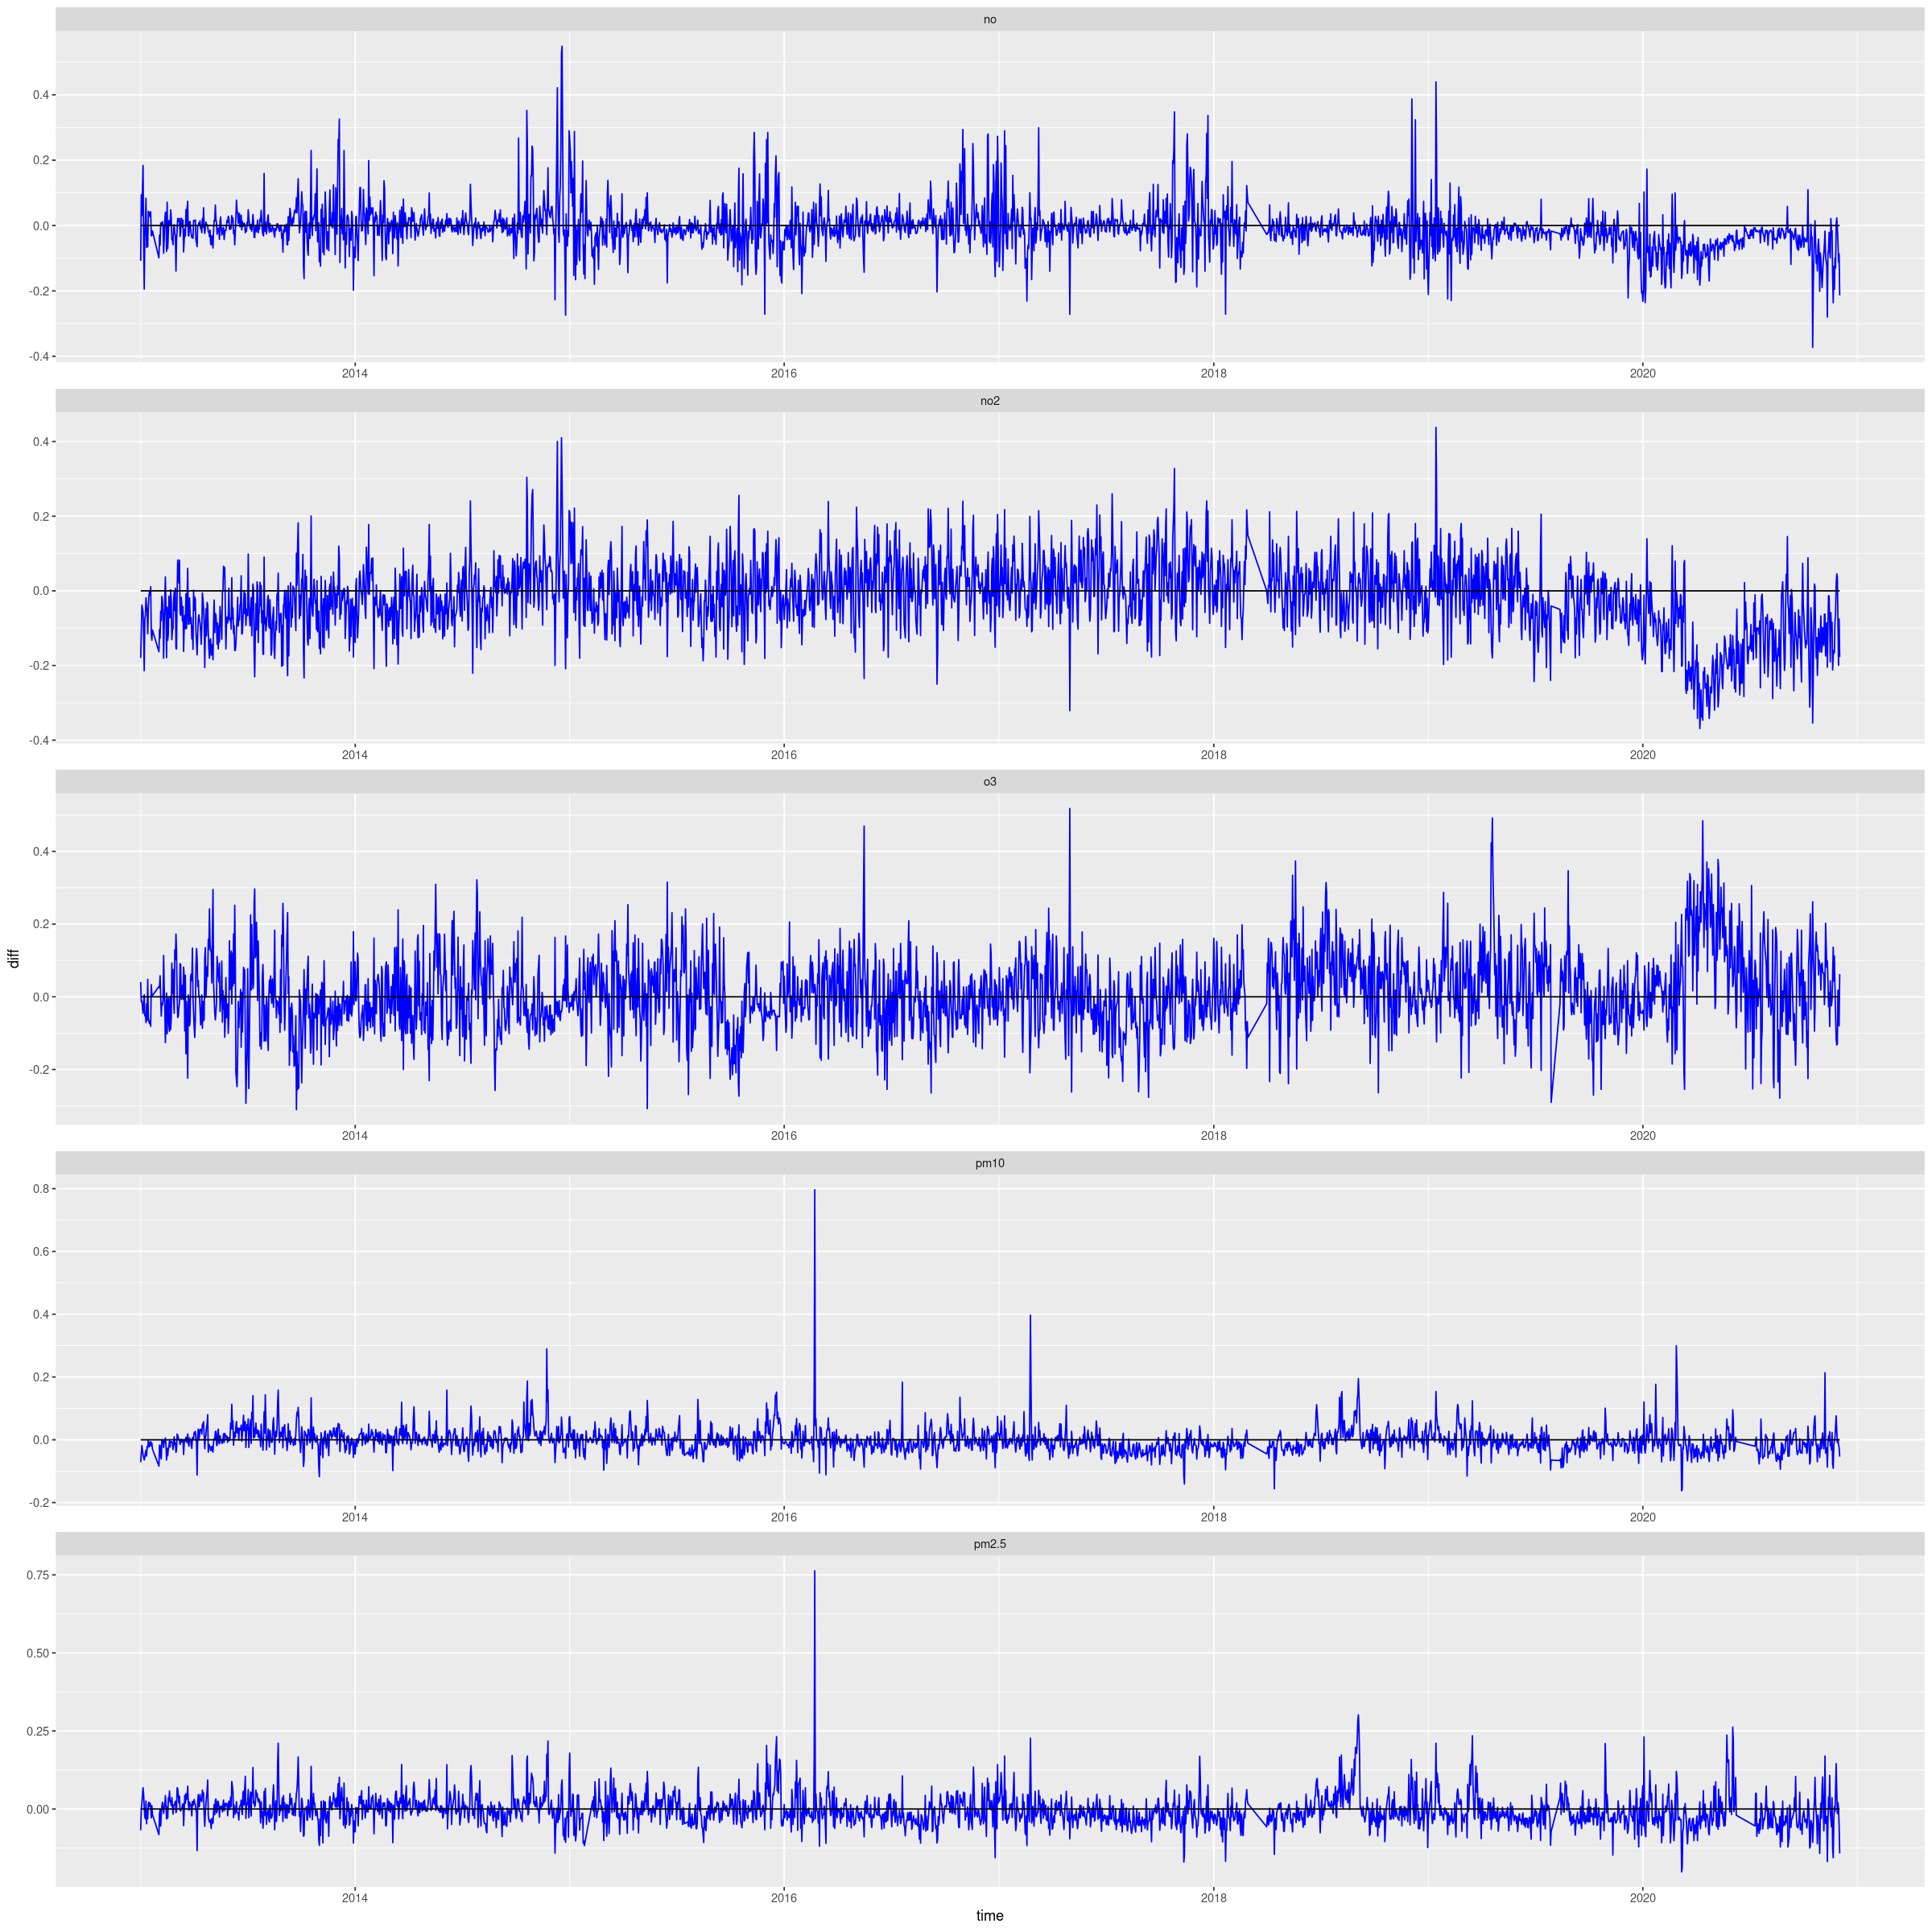

In [11]:
ggplot(model.df) +
    geom_line(aes(x=time, y=diff), color="blue") +
    geom_line(aes(x=time, y=0), color="black") +
    facet_wrap(~variable, scale="free", ncol=1)